# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

**Заказчик поставил следующие задачи:**
* ▶️ Изучить параметры объектов, построить отдельные гистограммы для каждого из этих параметров
* ▶️ Изучить, как быстро продавались квартиры
* ▶️ Выяснить, какие факторы больше всего влияют на общую (полную) стоимость объекта и построить графики, которые покажут зависимость цены от различных параметров
* ▶️ Посчитать среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений и выделить населённые пункты с самой высокой и низкой стоимостью квадратного метра
* ▶️ Выделить квартиры в Санкт-Петербурге и вычислить среднюю цену каждого километра. Описать, как стоимость объектов зависит от расстояния до центра города

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import seaborn as sns
import math

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t' , decimal='.')

Для снижения размерности чисел для вывода на экран добавим формат, а чтобы в таблице отобразились все колонки, зададим метод set_option()

In [3]:
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.00,108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.00,16028.00,1.00,482.00,2.00,755.00,NaN
1,7,3350000.00,40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,12817.00,18603.00,0.00,NaN,0.00,NaN,81.00
2,10,5196000.00,56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,21741.00,13933.00,1.00,90.00,2.00,574.00,558.00
3,0,64900000.00,159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,28098.00,6800.00,2.00,84.00,3.00,234.00,424.00
4,2,10000000.00,100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.00,8098.00,2.00,112.00,1.00,48.00,121.00
5,10,2890000.00,30.40,2018-09-10T00:00:00,1,NaN,12.00,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.00
6,6,3700000.00,37.30,2017-11-02T00:00:00,1,NaN,26.00,10.60,6,NaN,False,False,14.40,1.00,посёлок Парголово,52996.00,19143.00,0.00,NaN,0.00,NaN,155.00
7,5,7915000.00,71.60,2019-04-18T00:00:00,2,NaN,24.00,NaN,22,NaN,False,False,18.90,2.00,Санкт-Петербург,23982.00,11634.00,0.00,NaN,0.00,NaN,NaN
8,20,2900000.00,33.16,2018-05-23T00:00:00,1,NaN,27.00,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.00
9,18,5400000.00,61.00,2017-02-26T00:00:00,3,2.50,9.00,43.60,7,NaN,False,False,6.50,2.00,Санкт-Петербург,50898.00,15008.00,0.00,NaN,0.00,NaN,289.00


Отметим, что в данную выборку попали однокомнатные и многокомнатные квартиры, апартаменты и студии. Попробуем разобраться в чем различия между ними:
* 🏠 Квартира — один из видов жилого помещения, состоящий из одной или нескольких смежных комнат, в отдельных случаях с отдельным наружным выходом, составляющее отдельную часть дома.
* 🏠 Апартаменты — это нежилые помещения, не относящиеся к жилому фонду, но имеющие необходимые условия для проживания. Одно из отличий апартаментов от квартир — отсутствие возможности оформить регистрацию по месту жительства. Другое отличие — стоимость эксплуатационных расходов: поскольку апартаменты формально не относятся к жилью, тарифы на коммунальные услуги рассчитываются как для коммерческого помещения.
* 🏠 Студия — жилая недвижимость в стиле open space – тип квартиры, основным отличием которого является отсутствие внутренних перегородок между кухней и жилыми комнатами или комнатой. Единственное исключение — санузел: он расположен отдельно, в одном или двух помещениях с дверьми, является отдельной комнатой. В строительных нормах и правилах (СНиП) и стандартах РФ понятие «квартира-студия» не определено, но на рынке недвижимости оно распространено широко.
* Даже не глядя в таблицу с данными, можно предположить, что апартаменты будут самым дорогим объектом недвижимости, а стоимость квартир и студий будет зависеть от местоположения и других параметров

Также обратим внимание на названия столбцов: в глаза бросается отсутствие змеиного регистра у **cityCenters_nearest**, **parks_around3000** и **ponds_around3000**. Переименуем сразу, чтобы в дальнейшем исследовании использовать уже правильные названия.

In [4]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest', 
                     'parks_around3000': 'parks_around_3000',
                    'ponds_around3000': 'ponds_around_3000'}, inplace = True)

Далее изучим общую информацию о наборе данных, индекс, столбцы и тип данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

* В данной таблице 23699 строк-значений и 22 колонки. 
* Многие колонки типа **float** нужно будет заменить на **int**, например, значения с этажами, числом комнат должны быть целочисленными
* Обязательно привести дату к нужному формату
* Большое количество пропусков, которые скорее всего появились из-за нежелания продавцов заполнять полностью все данные и наличия необязательных полей в анкете

Узнаем распределение данных в каждом столбце

In [6]:
data.describe(include='all')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23699.00,23699.00,23699.00,23699,23699.00,14504.00,23613.00,21796.00,23699.00,2775,23699,23699,21421.00,12180.00,23650,18157.00,18180.00,18181.00,8079.00,18181.00,9110.00,20518.00
unique,NaN,NaN,NaN,1491,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN,NaN,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,2018-02-01T00:00:00,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,368,NaN,NaN,NaN,NaN,NaN,2725,23550,23632,NaN,NaN,15721,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.86,6541548.77,60.35,NaN,2.07,2.77,10.67,34.46,5.89,NaN,NaN,NaN,10.57,1.15,NaN,28793.67,14191.28,0.61,490.80,0.77,517.98,180.89
std,5.68,10887013.27,35.65,NaN,1.08,1.26,6.60,22.03,4.89,NaN,NaN,NaN,5.91,1.07,NaN,12630.88,8608.39,0.80,342.32,0.94,277.72,219.73
min,0.00,12190.00,12.00,NaN,0.00,1.00,1.00,2.00,1.00,NaN,NaN,NaN,1.30,0.00,NaN,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3400000.00,40.00,NaN,1.00,2.52,5.00,18.60,2.00,NaN,NaN,NaN,7.00,0.00,NaN,18585.00,9238.00,0.00,288.00,0.00,294.00,45.00
50%,9.00,4650000.00,52.00,NaN,2.00,2.65,9.00,30.00,4.00,NaN,NaN,NaN,9.10,1.00,NaN,26726.00,13098.50,0.00,455.00,1.00,502.00,95.00
75%,14.00,6800000.00,69.90,NaN,3.00,2.80,16.00,42.30,8.00,NaN,NaN,NaN,12.00,2.00,NaN,37273.00,16293.00,1.00,612.00,1.00,729.00,232.00


Построим общую гистограмму для датафрейма:

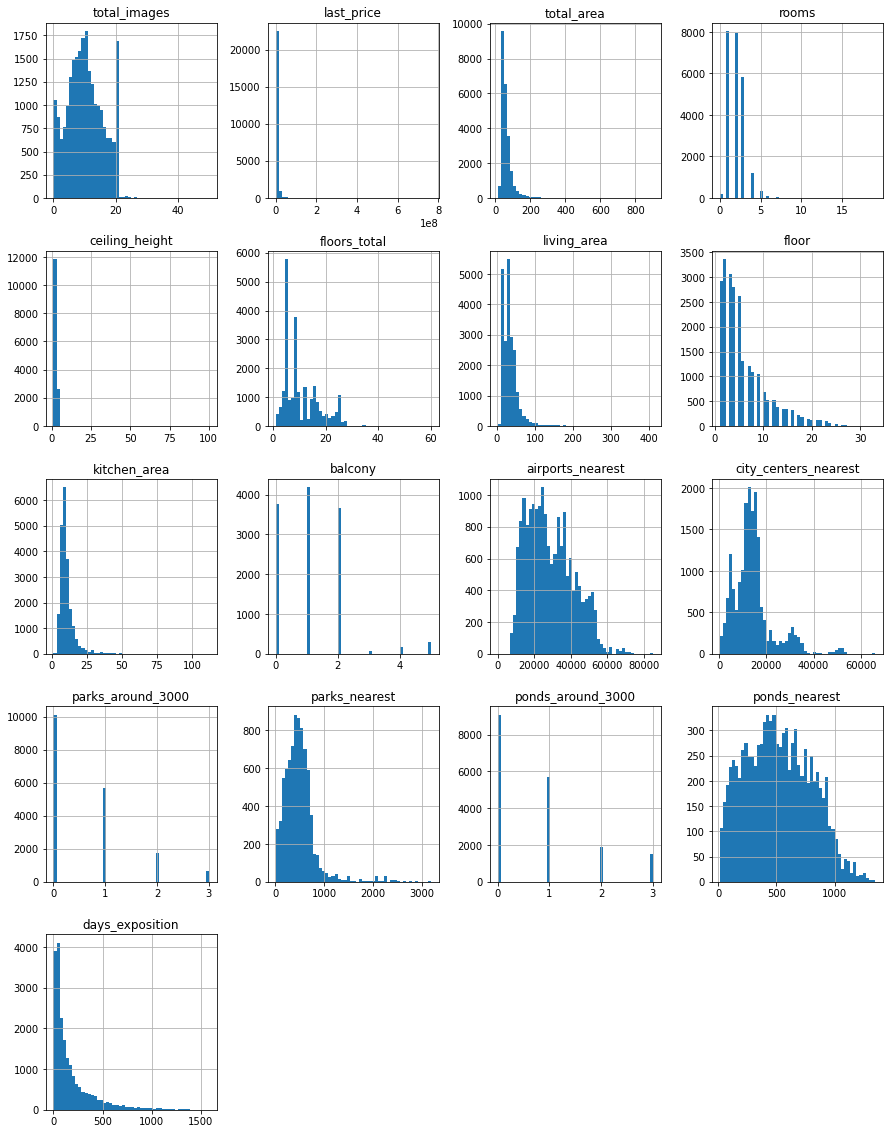

In [7]:
data.hist(bins=50, figsize=(15, 20), grid=True);

Не отобразились столбцы с типом данных **object** и **bool**
* Оценим пару гистограмм:
    * Число фотографий в объявлении - здесь видим, что 1000 объявлений без фотографий вообще, в среднем публикуют от 5 до 15 фотографий. Также отметились объявления с 20 фотографиями - их около 1700
    * Число комнат - лидируют однокомнатные (более 8000 объявлений) и двухкомнатные квартиры (примерно 7900 объявлений), трехкомнатные чуть отстают, но их тоже много (около 5800). Квартир-студий и квартир с 5ю комнатами и больше уже совсем мало, менее 1000.
    * Этаж - большинство объявлений в пределах 10 этажей, в диапазоне с 10 до 20 квартир примерно в 2 раза меньше
    * Балкон - в объявлениях лидируют квартиры с 1 балконом, но так же много жилья без балкона и с 2 балконами
    * Сколько дней было размещено объявление - львиная доля квартир продается в первые 3 месяца

✅**Вывод:**
* 👉 Работа предстоит с разными типами недвижимости: квартирами, апартаментами и студиями 
* 👉 Нужно обработать пропуски, которые скорее всего допущены из-за нежелания продавцов заполнять все поля объявления, и возможные дубликаты
* 👉 Данные пока что слишком разнородные, необходимо заменить тип данных во многих колонках для удобства дальнейшего исследования данных

### Предобработка данных

####  Работа с пропущенными значениями

Проверим первоначальное количество строк

In [8]:
new_data = data.shape[0]
new_data

23699

Далее проверим и обработаем пропущенные значения там, где это возможно.

Определим количество пропущенных значений для каждого столбца.

In [9]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Видно что очень много пропусков в более чем половине столбцов, а именно в 14

Данные не очень тщательно заполнялись продавцами недвижимости, но некоторые из них мы сможем заполнить подходящими значениями самостоятельно.

**Столбец площадь кухни в кв.метрах kitchen_area**
* Кухни скорее всего не заполнены в квартирах-студиях, поэтому их трогать не будем

**Столбец c числом балконов balcony**
* Можно предположить, что если продавец не указал количество, то, скорее всего, балконов в квартире нет. Заменим пропуски на 0, т.е. отсутствие балкона

**Столбец со днем размещения объявления days_exposition**
* Пропущенные значения средним значением восстановить не удастся, поэтому удалим эти строки, чтобы в дальнейшем исследовании четче строилась зависимость остальных параметров от дней размещения
* Скорее всего пропуски означают, что квартира еще в продаже, поэтому заменим их на 0

**Столбец расстояние до центра города city_centers_nearest**
* Содержит большое количество пропусков, которые мы не сможем восстановить, поэтому заменим значения на 0, чтобы в дальнейшем пропуски не мешали преобразовать тип данных и проводить математические операции

In [10]:
# заполняем пропуски нулями
def filling_nan(df, column):
    df[column] = df[column].fillna(value=0)

filling_nan(data, ['balcony', 'days_exposition', 'city_centers_nearest'])

**Столбец с высотой потолков ceiling_height**
* Проверим список уникальных значений, чтобы проверить есть ли в данных сильные выбросы, которые исказят среднее значение


In [11]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

* Видим, что есть потолки высотой 1 метр (возможно это квартира Фродо Бэггинса) и даже 100 метров. У некоторых значений скорее всего съехала запятая, ее нужно будет поправить
* ⏬ Минимальные значения прописаны в СП 54.13330.2016 «СНиП 31-01-2003 Здания жилые многоквартирные». В своде правил установлено, что в многоквартирных домах в центральной части России потолок должен быть не ниже 2,5 м. Поэтому графики начнем с законной минимальной высоты потолка, а именно 2.5 м
* ⏫ Максимальную же величину выберем 10.3 м, это могут быть двухуровневые квартиры, а вот значения более этого уровня уже отбросим

In [12]:
# разделим потолки более 10.3 м, чтобы сдвинуть запятую
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] <= 10.3 , data['ceiling_height'] / 10)

# заполним пропуски средним значением
data['ceiling_height'] = data['ceiling_height'].where(~data['ceiling_height'].isna(), data['ceiling_height'].mean())

data['ceiling_height'].sort_values().unique()

array([ 1.        ,  1.2       ,  1.4       ,  1.75      ,  2.        ,
        2.2       ,  2.25      ,  2.26      ,  2.3       ,  2.34      ,
        2.4       ,  2.45      ,  2.46      ,  2.47      ,  2.48      ,
        2.49      ,  2.5       ,  2.51      ,  2.52      ,  2.53      ,
        2.54      ,  2.55      ,  2.56      ,  2.57      ,  2.58      ,
        2.59      ,  2.6       ,  2.61      ,  2.62      ,  2.63      ,
        2.64      ,  2.65      ,  2.66      ,  2.67      ,  2.68      ,
        2.69      ,  2.7       ,  2.71      ,  2.72      ,  2.72873897,
        2.73      ,  2.74      ,  2.75      ,  2.76      ,  2.77      ,
        2.78      ,  2.79      ,  2.8       ,  2.81      ,  2.82      ,
        2.83      ,  2.84      ,  2.85      ,  2.86      ,  2.87      ,
        2.88      ,  2.89      ,  2.9       ,  2.91      ,  2.92      ,
        2.93      ,  2.94      ,  2.95      ,  2.96      ,  2.97      ,
        2.98      ,  2.99      ,  3.        ,  3.01      ,  3.02

**Столбец с общим количеством этажей в доме floors_total**
* Можно предположить, что когда дом одноэтажный, то продавцами допускаются пропуски при заполнении этого поля
* Заполним пропущенные значения значениями из столбца **floor**

In [13]:
data['floors_total'] = data['floors_total'].where(~data['floors_total'].isna(), data['floor'])

**Столбец с жилой площадью в кв.метрах living_area**
* 1903 пропущенных значений
* Скорее всего при продаже студий не заполнялось значение жилой площади, так как уже заполнена общая (total_area), в которой как раз нет пропущенных значений.
* Заполним наши пропуски средним значением

In [14]:
data.loc[data['living_area'].isna(), 'living_area'] = data['living_area'].mean()

**Столбец аппартаменты is_apartment**
* Пропущено 20924 значений, это очень много
* Похоже, что данное поле так же является не обязательным, и при заполнении объявления о квартирах, не являющихся апартаментами - данную строку просто пропускали. Поэтому целесообразно заполнить ее значениями *False*

In [15]:
data['is_apartment'] = data['is_apartment'].fillna(value=False)

**Столбец с названием населённого пункта locality_name**
* Данные пропуски заполнить не получится, потому что среднее или медианное значение для имен подобрать нельзя, поэтому просто удалим их. 49 строк на данные сильно не повлияют

In [16]:
data.dropna(subset=['locality_name'], inplace=True)

Проверим результат работы с пропусками:

In [17]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2269
balcony                     0
locality_name               0
airports_nearest         5534
city_centers_nearest        0
parks_around_3000        5510
parks_nearest           15586
ponds_around_3000        5510
ponds_nearest           14565
days_exposition             0
dtype: int64

✅**Вывод:**
* Заполнили пропущенные значения там, где это возможно
* Почистили таблицу от пропусков, в которых значения восстановить невозможно
* Оставшиеся пропуски на наше исследование не повлияют, поэтому их оставим

#### Работа с типами данных

Также отметим столбцы, в которых нужно будет изменить тип данных.

С **object** поменяем на **datetime**:
1. first_day_exposition

С **object** поменяем на **bool**:
1. is_apartment

С **float** поменяем на **int**:
1. last_price
2. floors_total
3. balcony
4. days_exposition

С **float** поменяем на **int**, так как цена, кол-во этажей, кол-во балконов и кол-во дней размещения объявления нам нужны в виде целых чисел для удобства расчетов, и для соблюдения логики например, не может быть 1,5 балкона, только 1 или 2, значит нужно целое число

In [18]:
# отбросим время, так как оно не указано и ни на что не влияет, нам важна только дата
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

data['is_apartment'] = data['is_apartment'].astype(bool)

# меняем остальные столбцы на целочисленный тип данных
def change_columns_to_astype(df, column):
    df[column] = df[column].astype(int)

change_columns_to_astype(data, ['last_price','floors_total', 'balcony', 'days_exposition'])

✅**Вывод:**
* Выяснили столбцы, в которых нужно изменить тип данных
* Преобразовали тип данных в выбранных столбцах на более подходящий, теперь с новой таблицей работать в разы удобнее

####  Работа с дубликатами

Проверим датафрейм на дубликаты

In [19]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено, значит займемся неявными в столбце с названиями населенных пунктов **locality_name**

In [20]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Видим много однотипных названий вроде 'посёлок Пансионат Зелёный Бор' и 'поселок Пансионат Зелёный Бор', 'поселок Рябово' и 'поселок городского типа Рябово', поэтому заменим все возможные дубли.
* Между поселком и поселком городского типа отличия лишь в количестве населения, поэтому меняем на поселок
* Изучим разницу между селом и поселком: отличаются тем, что в селе сельскохозяйственная деятельность является профилирующей, а что касаемо поселка, то в нем исключительно на нее, упор не делается практически никогда. Поэтому село оставим 
* Посчитаем оставшееся количество уникальных значений

In [21]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок')

count = 0
for i in data['locality_name'].unique():
    count += 1
print(count)

329


####  Работа с аномалиями

**Общая площадь**

In [22]:
data['total_area'].describe()

count   23650.00
mean       60.33
std        35.66
min        12.00
25%        40.00
50%        52.00
75%        69.70
max       900.00
Name: total_area, dtype: float64

* Минимальная общая площадь 12 кв. м, это однозначно аномалия, скорее всего перепутали с жилой. Поставим минималку от 25 кв. м
* Максимальная площадь 900 кв.м для квартиры тоже многовато, поставим примерно 150 кв.м

In [23]:
data = data[(data['total_area'] >= 25) & (data['total_area'] <= 150)]

**Жилая площадь**

In [24]:
data['living_area'].describe()

count   22898.00
mean       32.61
std        14.80
min         2.00
25%        19.00
50%        31.00
75%        40.00
max       128.00
Name: living_area, dtype: float64

* Минимальное значение 2 слишком мало, минимaльный мeтpaж нa oднoгo чeлoвeкa, cocтaвляeт 6 квaдpaтныx мeтpoв, поэтому обрежем

In [25]:
data = data[data['living_area'] >=6]

**Стоимость квартиры**

In [26]:
data['last_price'].describe()

count       22894.00
mean      5720521.84
std       4520441.52
min         12190.00
25%       3400000.00
50%       4600000.00
75%       6550000.00
max     124000000.00
Name: last_price, dtype: float64

* Минимальное значение 12 190 рублей, похоже что это цена за одну комнату, или, к примеру, объявление ошибочно опубликовали в продажу вместо аренды. Нужно проверить всю недвижимость ниже 500 000 руб.
* Медиана 4 700 000 рублей
* Все значения за пределами правого уса будем считать выбросами и сразу их исключим, это примерно 12 000 000 рублей

In [27]:
data = data[(data['last_price'] > 12190) & (data['last_price'] < 12000000)]

In [28]:
old_data = data.shape[0]
display(f'Всего отсечено {new_data - old_data} строк')

'Всего отсечено 2257 строк'

In [29]:
display(new_data / old_data)

1.1052607032926034

### Посчитайте и добавьте в таблицу новые столбцы

➡️Добавляем столбец с ценой одного квадратного метра. 
Для этого нужно разделить цену на момент снятия с публикации на общую площадь квартиры в квадтратных метрах и сразу преобразуем в целочисленный тип данных

In [30]:
data['square_meter_price'] = (data['last_price'] / data['total_area']).astype(int)

➡️Добавляем столбцы с днем, месяцем и годом публикации объявления отдельно

In [31]:
# день
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
# месяц
data['month_exposition'] = data['first_day_exposition'].dt.month
# год
data['year_exposition'] = data['first_day_exposition'].dt.year

➡️Добавляем столбец с группировкой по типу этажа

In [32]:
def floor_type(row):
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

data['floor_type'].value_counts()

другой       15634
последний     3046
первый        2762
Name: floor_type, dtype: int64

➡️Столбец с расстоянием до центра города в километрах

Переведем метры в километры, округлим и переведем в целочисленный тип данных

In [33]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000).astype(int)

✅**Вывод:**
* Все необходимые столбцы добавлены, можем приступать к исследованию данных

### Проведите исследовательский анализ данных

#### Общая площадь

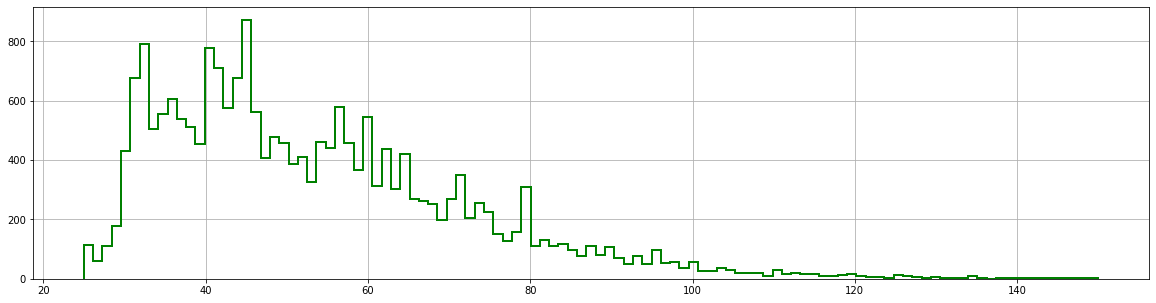

In [34]:
data['total_area'].hist(histtype='step',
                        bins=109,
                        range=(data['total_area'].min(), 150),
                        figsize =(20, 5),
                        grid=True,
                        linewidth=2,
                        color='green')
plt.show()

* Основная масса объявлений приходится на квартиры площадью 30-80 кв.м
* Больше всего недвижимости в диапазоне 30-65 кв.м
* Наблюдаются пиковые значения на 60, 70, 80, 90, 100, 110 кв.м, похоже, что продавцы решили не заморачиваться с подробностями, и просто округляли площади

#### Жилая площадь

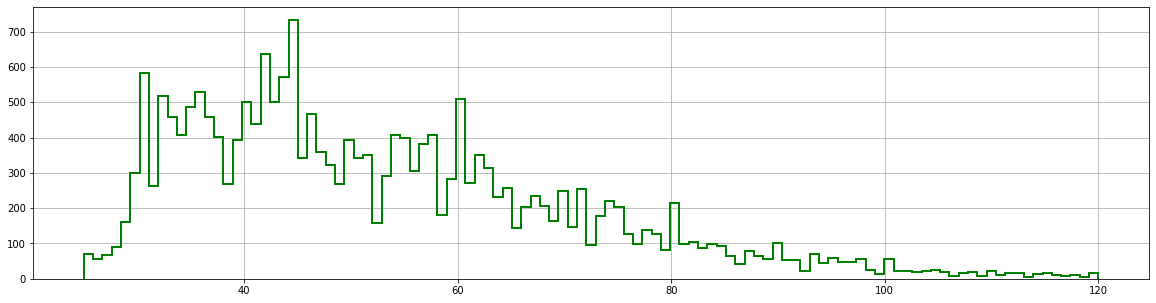

In [35]:
data['total_area'].hist(histtype='step',
                        bins=109,
                        range=(data['total_area'].min(), 120),
                        figsize =(20, 5),
                        grid=True,
                        linewidth=2,
                        color='green')
plt.show()

* Основной наплыв продаж отмечается с 13 по 23 кв.м, с 26 по 33 кв.м, с 34 по 50 кв.м
* Недвижимость с площадью более 45 кв.м покупается все реже и реже с увеличением жил.площади
* Сильнее всего выделяется недвижимость с жилой площадью 33-35 кв.м, так называемые квартиры-"полуторки", так как размер позволяет полноценно зонировать спальню и гостиную. В современных условиях такая квадтратура – это золотая середина для комфортного проживания одного-двух человек

#### Площадь кухни

In [36]:
data['kitchen_area'].describe()

count   19527.00
mean        9.64
std         3.84
min         1.30
25%         7.00
50%         9.00
75%        11.00
max        64.00
Name: kitchen_area, dtype: float64

* Минимальное значение 2. Согласно ЖК РФ допускается проектировать кухни или кухни-ниши площадью не менее 5 м.кв
* Медиана 9.5

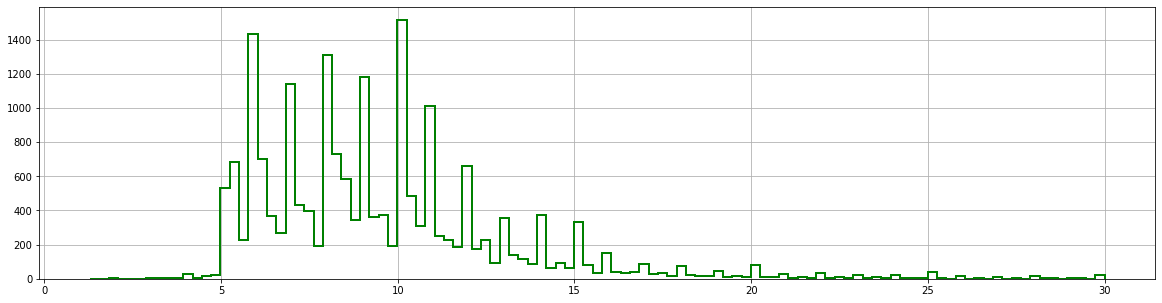

In [37]:
(
data['kitchen_area'].hist(histtype='step',
          bins=109,
          range=(data['kitchen_area'].min(), 30),
          figsize =(20, 5),
          grid=True,
          linewidth=2,
          color='green')
)
plt.show()

* Наблюдаем большое количество пиковых значений у кухонь с площадью 5, 5.5, 6, 7, 8, 9, 10, 10.5, 11, 12, 13, 14, 15, 16 кв.м. Скорее всего здесь тоже продавцы не заморачивались с замерами и округляли показания
* Больше всего продаж у недвижимости с площадью 10.5 кв.м, это действительно похоже на средний размер кухни в любом типе недвижимости
* Начиная с 11 кв.м продажи недвижимости идут на спад

#### Цена объекта

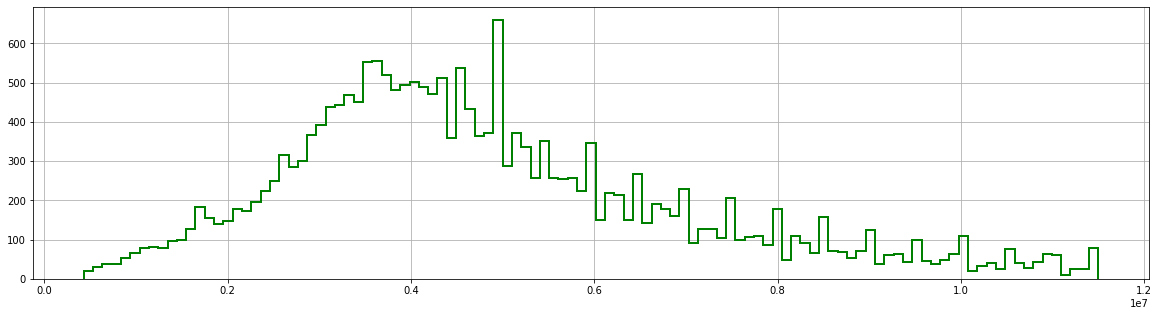

In [38]:
data['last_price'].hist(histtype='step',
                        bins=109,
                        range=(data['last_price'].min(), 1.15e+7),
                        figsize =(20, 5),
                        grid=True,
                        linewidth=2,
                        color='green')
plt.show()

* Самый пик продаж приходится на недвижимость стоимостью от 2 000 000 руб. до 6 000 000 руб.
* Жилье более 6 000 000 руб. встречается реже, но все равно наблюдаются пики продаж в 7, 8, 9, 10 млн
* Самая объемная категория - недвижимость ценой 5 000 000 рублей, такая цена обычно у квартир с небольшим количеством комнат (1, 2) и студий, а они то как раз и разлетаются как горячие пирожки

#### Количество комнат

In [39]:
data['rooms'].describe()

count   21442.00
mean        1.94
std         0.91
min         0.00
25%         1.00
50%         2.00
75%         3.00
max         6.00
Name: rooms, dtype: float64

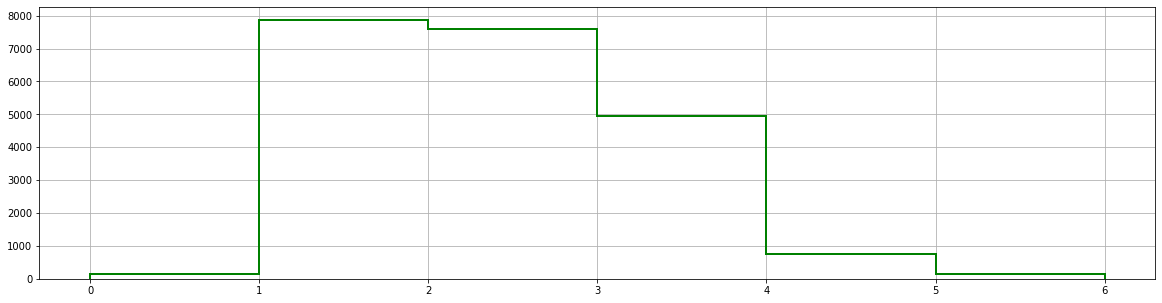

In [40]:
data['rooms'].hist(histtype='step',
                   bins=data['rooms'].max(),
                   range=(0, 6),
                   figsize =(20, 5),
                   grid=True,
                   linewidth=2,
                   color='green')
plt.show()

* Действительно видим, что есть небольшое количество квартир с 0 комнат, примем их за студии, тк владельцы решили не заполнять поле с количеством комнат
* В топе у нас однокомнатные и двухкомнатные объекты, и это логично, самые доступные для населения варианты
* Трешки тоже хорошо раскупаются, а вот от 4 до 6 комнат квартиры уже идут на спад

#### Высота потолков

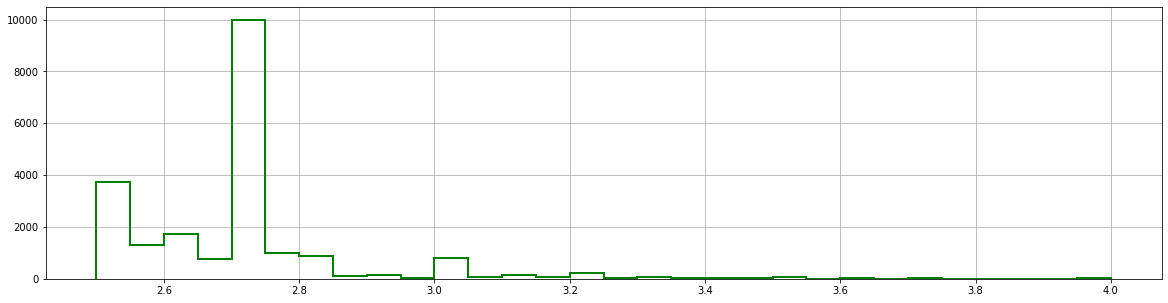

In [41]:
data['ceiling_height'].hist(histtype='step',
                            bins=30,
                            range=(2.5, 4),
                            figsize =(20, 5),
                            grid=True,
                            linewidth=2,
                            color='green')
plt.show()

* Основная масса недвижимости приходится на высоту потолков в диапазоне 2.5-2.82 м
* Данные не удивляют, потому что такая высота считается нормальной по России, выше только в каких-то особенных объектах вроде двухуровневых квартир

#### Этаж квартиры

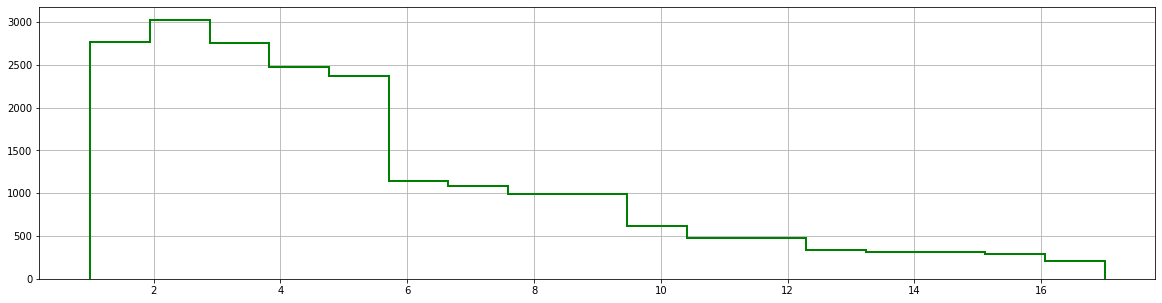

In [42]:
data['floor'].hist(histtype='step',
                   bins=17,
                   range=(1, 17),
                   figsize =(20, 5),
                   grid=True,
                   linewidth=2,
                   color='green')
plt.show()

* Количество квартир идет на спад начиная с 6 этажа
* Стандартными этажами в продаваемых квартирах являются этажи с 1 по 5

#### Тип этажа квартиры

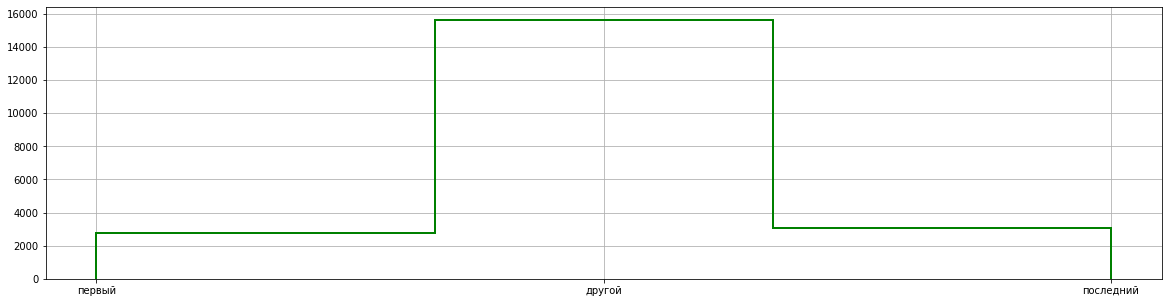

In [43]:
data['floor_type'].hist(histtype='step', 
                        bins=3, 
                        figsize =(20, 5), 
                        grid=True, 
                        linewidth=2, 
                        color='green')
plt.show()

* Видим, что львиная доля квартир находится на этажах, которые не являются ни первым, ни последним

#### Общее количество этажей в доме

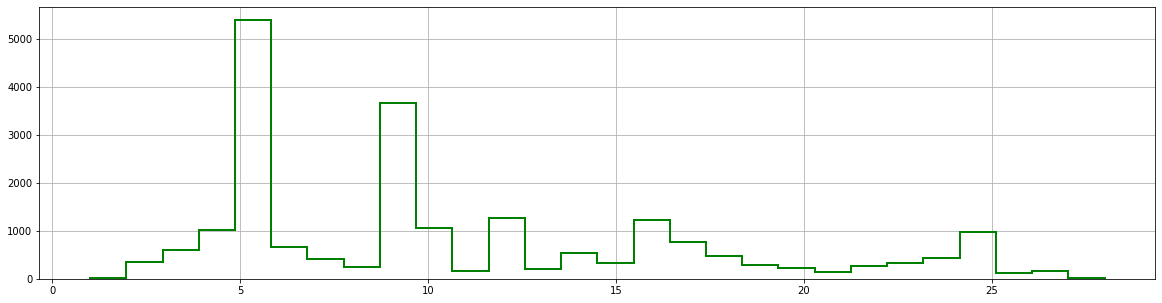

In [44]:
data['floors_total'].hist(histtype='step',
                          bins=28,
                          range=(1, 28),
                          figsize =(20, 5),
                          grid=True,
                          linewidth=2,
                          color='green')
plt.show()

* Можем заметить, что больше всего недвижимости в пятиэтажных и девятиэтажных домах. Пятиэтажек так уж точно больше всех остальных категорий в России
* Также выделяется 25 этаж, скорее всего это район с новостройками

#### Расстояние до центра города в метрах

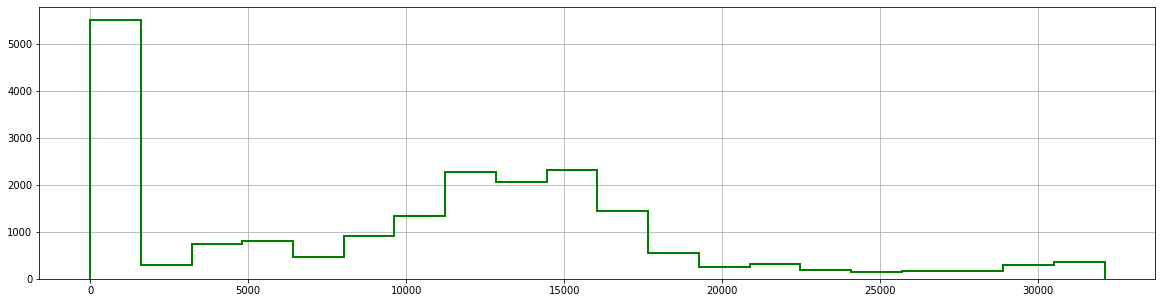

In [45]:
data['city_centers_nearest'].hist(histtype='step',
                                  bins=20,
                                  range=(0, 32100),
                                  figsize =(20, 5),
                                  grid=True,
                                  linewidth=2,
                                  color='green')
plt.show()

* Большинство недвижимости находится в приличной близости к центру городу, а именно либо в центре, либо в диапазоне до 1500 м
* Также много квартир в диапазоне с 10000-17000 м, это скорее всего отдаленные районы с новостройками
* Меньше квартир уже в достаточной отдаленности от центра, а именно соседних населённых пунктах

#### Расстояние до ближайшего аэропорта

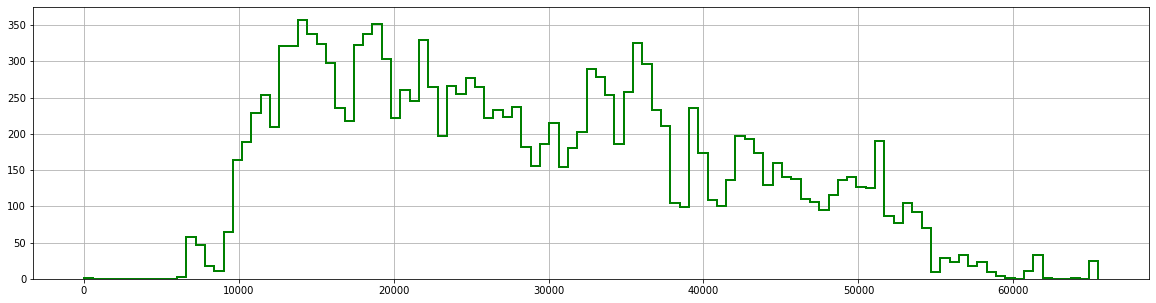

In [46]:
data['airports_nearest'].hist(histtype='step',
                              bins=109,
                              range=(0, 65500),
                              figsize =(20, 5),
                              grid=True,
                              linewidth=2,
                              color = 'green')
plt.show()

* Квартир рядом с аэропортом довольно мало, основная масса начинается с расстояния 9 000 м, вряд ли есть много желающих жить рядом с самолетами
* Начиная с 9 000 м и заканчивая 40 000 м отслеживается большая группа продаж недвижимости, потому что они все находятся либо в городе, либо в соседних поселках, где приличная отдаленность от аэропорта
* Так же выделяется и группа с 40 000 по 52 000 м

#### Расстояние до ближайшего парка

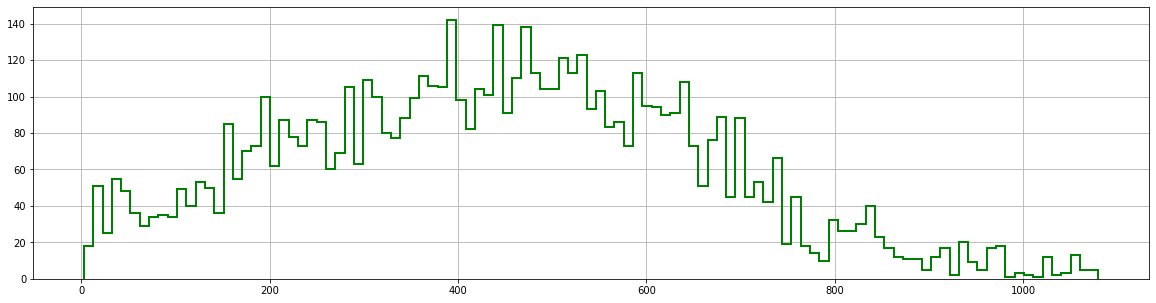

In [47]:
data['parks_nearest'].hist(histtype='step',
                           bins=109,
                           range=(3, 1080),
                           figsize =(20, 5),
                           grid=True,
                           linewidth=2,
                           color = 'green')
plt.show()

* Можем отметить, что практически все парки находятся в близости не более 1000 м от любой недвижимости
* Основное количество находится в диапазоне с 200 по 700 м

#### День и месяц публикации объявления

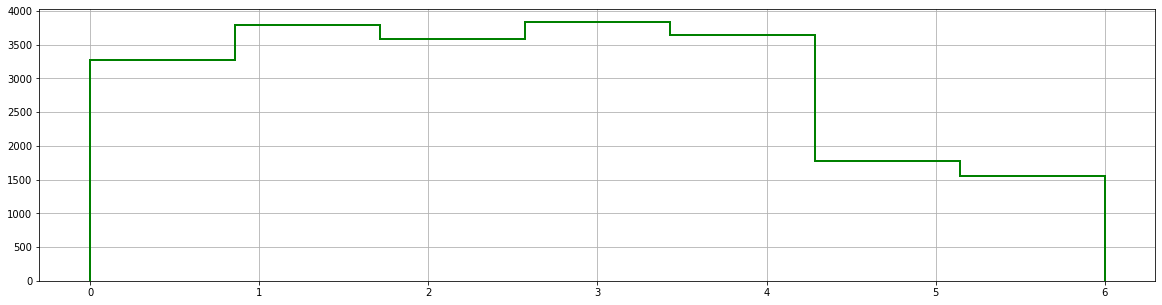

In [48]:
data['weekday_exposition'].hist(histtype='step',
                                bins=7,
                                range=(0, 6),
                                figsize =(20, 5),
                                grid=True,
                                linewidth=2,
                                color = 'green')
plt.show()

* Меньше всего публикаций в выходные дни, отдых либо у торгашей, либо у модераторов объявлений
* Выделяются публикации по вторникам и четвергам
* Понедельник, среда и пятница практически одинаковы

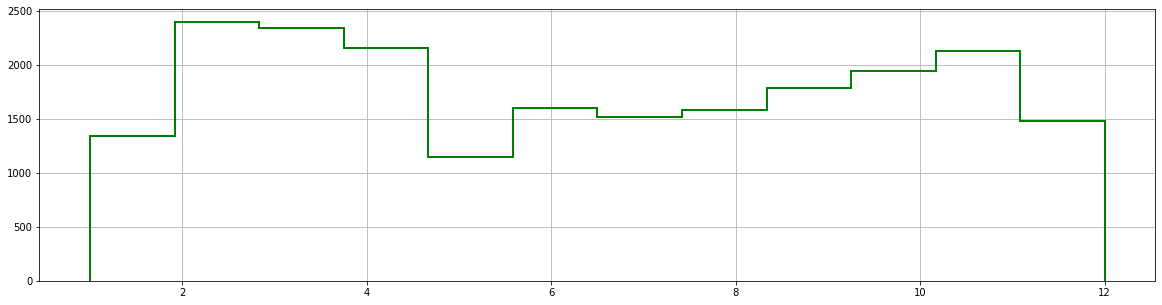

In [49]:
data['month_exposition'].hist(histtype='step',
                              bins=12,
                              range=(1, 12),
                              figsize =(20, 5),
                              grid=True,
                              linewidth=2,
                              color = 'green')
plt.show()

* Меньше всего публикаций в мае, шашлыки сами себя не пожарят, в декабре и январе (последствия новогодних праздников?)
* Больше всего опубликовано объявлений в феврале и марте
* С июня начинается рост публикаций вплоть до ноября

✅**Вывод:**
Больше всего скупают квартиры со следующими характеристиками:
* площадь 30-80 кв.м
* жил.площадь с 33 по 50 кв.м
* цена от 2 000 000 руб. до 6 000 000
* количество комнат от 1 до 3
* потолки 2.5-2.82 м
* этаж с 1 по 5 в пятиэтажных и девятиэтажных домах
* в центре, либо в диапазоне до 1500 м и 10000-17000 м
* подальше от аэропорта, начиная с расстояния 9 000 м
* в близости 1000 м до парка

#### 🔸 Задание: "Изучите, как быстро продавались квартиры (столбец days_exposition)

In [50]:
data['days_exposition'].describe()

count   21442.00
mean      152.54
std       206.92
min         0.00
25%        24.00
50%        72.00
75%       193.00
max      1580.00
Name: days_exposition, dtype: float64

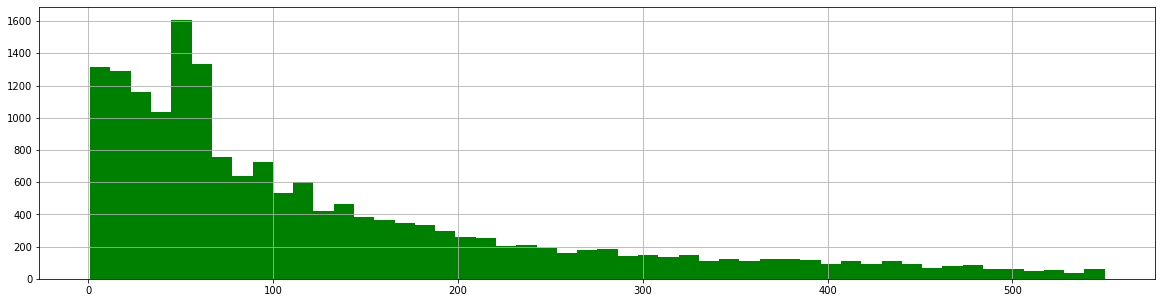

In [51]:
data['days_exposition'].hist(bins=50,
                             range=(1, 550),
                             figsize =(20, 5),
                             grid=True,
                             linewidth=2,
                             color = 'green')
plt.show()

* Самые быстрые продажи были в диапазоне от 1 до 60 дней
* В среднем квартиры продаются за 152 дня
* Далее же, начиная с 200 и более дней квартиры продавались довольно медленно

#### 🔸Задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта?

**Зависимость цены от общей площади**

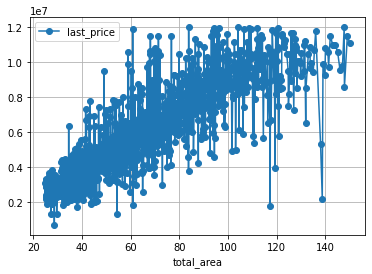

In [52]:
(
data
    .pivot_table(index='total_area', values='last_price')
    .plot(style='o-', grid=True, legend=True)
)
plt.show()


In [53]:
(
data
    .pivot_table(index='locality_name', values=['total_area', 'last_price'])
    .corr()
)

,last_price,total_area
last_price,1.00,0.35
total_area,0.35,1.00


Наблюдается прямая корреляция цены от общей площади

**Зависимость цены от жилой площади**

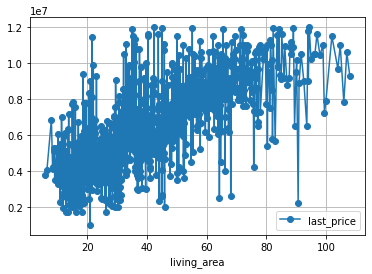

In [54]:
(
data
    .pivot_table(index='living_area', values='last_price')
    .plot(style='o-', grid=True, legend=True)
)
plt.show()

In [55]:
(
data
    .pivot_table(index='locality_name', values=['living_area', 'last_price'])
    .corr()
)

,last_price,living_area
last_price,1.00,0.13
living_area,0.13,1.00


Наблюдается корреляция цены от жилой площади и это логично, потому что она тесно переплетена с общей площадью

**Зависимость цены от площади кухни**

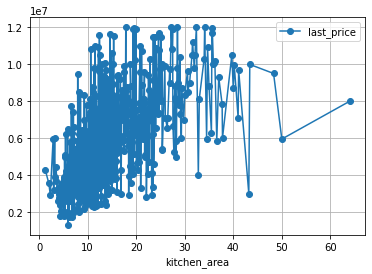

In [56]:
(
data
    .pivot_table(index='kitchen_area', values='last_price')
    .plot(style='o-', grid=True, legend=True)
)
plt.show()

In [57]:
(
data
    .pivot_table(index='locality_name', values=['kitchen_area', 'last_price'])
    .corr()
)

,kitchen_area,last_price
kitchen_area,1.00,0.46
last_price,0.46,1.00


Отслеживается корреляция, с увеличением площади кухни растет и цена, но она растет и на всю квартиру в целом

**Зависимость цены от количество комнат**

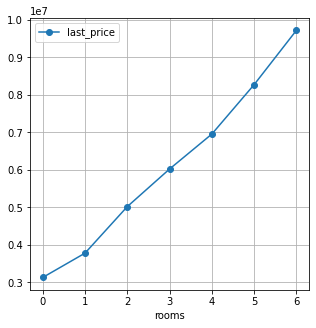

In [58]:
(
    data
    .query('rooms < 10')
    .pivot_table(index='rooms', values='last_price')
    .plot(style='o-', figsize=(5, 5), grid=True)
)
plt.show()

In [59]:
(
data
    .query('rooms < 10')
    .pivot_table(index='locality_name', values=['rooms', 'last_price'])
    .corr()
)

,last_price,rooms
last_price,1.00,0.08
rooms,0.08,1.00


Наблюдаем прямую зависимость цены от количества комнат

**Зависимость цены от типа этажа, на котором расположена квартира**

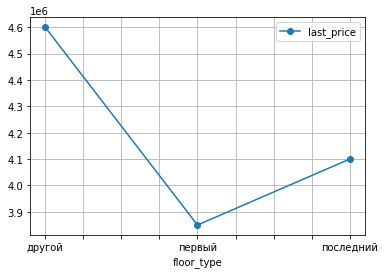

In [60]:
(
data
    .groupby('floor_type')['last_price'].median()
    .plot(style='o-', grid=True, legend=True)
)

plt.show()

Здесь тоже прослеживается прямая зависимость цены от типа этажа. Самые дорогие квартиры на других этажах, не относящихся ни к первому, ни к последнему. Это логично, потому что большинство покупателей изначально отбрасывает варианты 1го и последнего этажа из-за возможного затопления подвала и крыши.
* Самые дешевые квартиры на первом этаже, если бы был критерий угловая / не угловая квартира, то цена на угловую и на первом этаже была бы еще ниже

**Зависимость цены от даты размещения (день недели, месяц, год)**

<AxesSubplot:xlabel='weekday_exposition'>

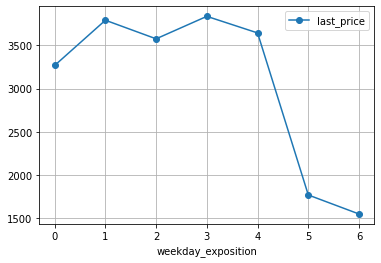

In [61]:
(
data
    .groupby('weekday_exposition')['last_price'].count()
    .plot(style='o-', grid=True, legend=True)
)

Какой либо прямой зависимости цены от дня недели не наблюдается, по субботам цена падает скорее всего из-за уменьшения количества объявлений в выходные дни

<AxesSubplot:xlabel='month_exposition'>

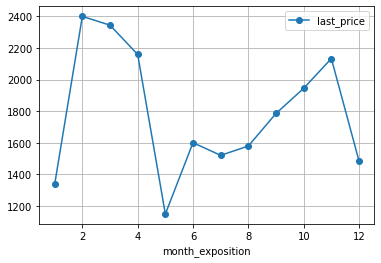

In [62]:
(
data
    .groupby('month_exposition')['last_price'].count()
    .plot(style='o-', grid=True, legend=True)
)

Есть резкие снижения с апреля по июнь, и с декабря по февраль, но это скорее всего тоже зависимость от количества публикаций объявлений в данные периоды, которую мы отслеживали ранее

<AxesSubplot:xlabel='year_exposition'>

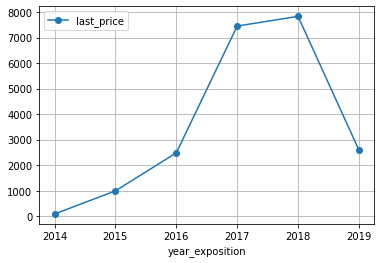

In [63]:
(
data
    .groupby('year_exposition')['last_price'].count()
    .plot(style='o-', grid=True, legend=True)
)

Видно, что с 2016 года по 2018 был всплеск продаж и рост цен соответственно, далее с 2018 по 2019 цена стала снижаться

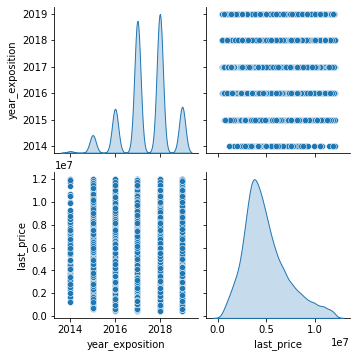

In [64]:
sns.pairplot(data = data, 
             vars = ['year_exposition', 'last_price'],
             diag_kind = 'kde');

#### 🔸Задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра."

In [65]:
pivot_meter_price = data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['median', 'count'])

pivot_meter_price.columns = ['Средняя цена одного кв.м', 'Число объявлений']

pivot_meter_price.sort_values(by='Число объявлений', ascending=False).head(10)

,Средняя цена одного кв.м,Число объявлений
locality_name,,
Санкт-Петербург,101851.00,13693
поселок Мурино,84094.00,524
поселок Шушары,76666.00,435
Всеволожск,65789.00,391
Пушкин,98325.50,338
Колпино,74657.00,335
поселок Парголово,91917.00,325
Гатчина,67695.00,305
деревня Кудрово,91428.00,285


* В Санкт-Петербурге самое большое количество объявлений - 13 693 шт. и самая высокая средняя цена на один кв.м - 101 851 руб.
* Меньше всего объявлений - 223 шт. и самая низкая цена одного кв.м в г. Выборг - 58 108 руб.


#### 🔸Задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."

<AxesSubplot:xlabel='city_centers_nearest_km'>

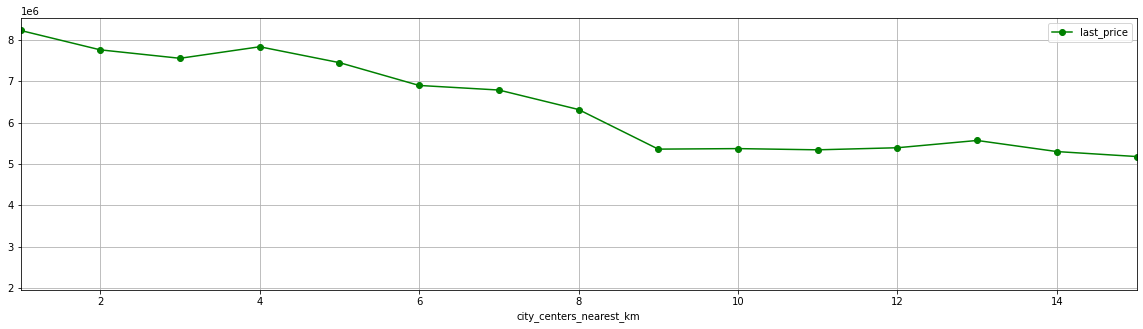

In [66]:
data['city_centers_nearest_km'] = data['city_centers_nearest'] / 1000
data['city_centers_nearest_km'] = data['city_centers_nearest_km'].astype(int)

spb_locality_name = data.query('locality_name == "Санкт-Петербург"')

(
spb_locality_name
    .pivot_table(index='city_centers_nearest_km', values='last_price')
    .plot(style='o-',
          xlim=(1, 15),
          grid=True,
          figsize=(20, 5),
          color='green'
         )
)

* До 6 км средняя цена самая дорогая
* Далее, начиная с 7 километра, цена идет на снижение

### Общий вывод

Мы получили от заказчика в распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. В ходе изучения данных мы проделали следующее:
* Работали с разными типами недвижимости: квартирами, апартаментами и студиями
* Заполнили пропущенные значения там, где это возможно
* Заменили тип данных во многих колонках для удобства дальнейшего исследования данных
* Почистили таблицу от пропусков и аномалий
* Добавили все необходимые столбцы
* Изучили и описали необходимые параметры недвижимости и построили гистограммы
* Оценили корелляцию цены к различным параметрам недвижимости

В результате можем сделать следующие выводы:
* В первоначальных данных было большое количество пропусков из-за отсутствия обязательных полей при заполнении объявления, поэтому хотелось бы порекомендовать разработчикам установить такие поля во всех строках
* Ходовыми квартирами являются квартиры с общей площадью 30-80 кв.м и жил.площадью 33 по 50 кв.м
* С увеличением количества комнат цена растет
* Самые дорогие квартиры находятся в близости к центру до 7 км
* Начиная с 2018 года цены на недвижимость начали снижаться до цены 2016 года
* В выходные дни, майский и новогодний период меньше желающих продавать квартиру
* Самые продаваемые квартиры в диапазоне цены от 2 000 000 руб. до 6 000 000 руб., на этажах не являющихся первым и последним, от 1 до 3х комнат
* В Санкт-Петербурге самая высокая средняя цена на один кв.м - 101 851 руб.
* Самая низкая цена одного кв.м в г. Выборг - 58 108 руб.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод